# Neural Netwwork from scratch

## Package import and prepare our workspace 

In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## Generate Data sets

Text(0.5, 1.0, 'Data set visualization')

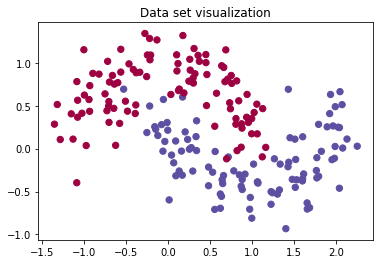

In [2]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.title("Data set visualization")

## Train logistic regression model

In [3]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

c:\users\wael\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [4]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values to get the boundaries of the plot area and enlarge with .5 each axe
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and predict function area 
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.YlOrBr)

Text(0.5, 1.0, 'Logistic Regression classification')

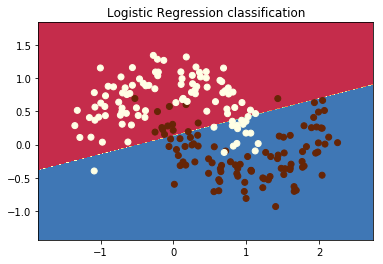

In [5]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression classification" )

The graph shows the decision boundary learned by our Logistic Regression classifier. 
It separates the data as good as it can using a straight line, but it's obvoious that it far from being a good classifier !!

In [6]:
from IPython.display import Image
from IPython.display import display
display(Image(url='nural-network-banner.gif'))

In [7]:
num_examples  = len(X) # number of inputs
nn_input_dim  = 2      # input layer dimensionality
nn_output_dim = 2      # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon       = 0.01   # learning rate for gradient descent
reg_lambda    = 0.01   # regularization strength

we calculate our prediction ŷ  (also two-dimensional) as follows:

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

$z_i$ is the weighted sum of inputs of layer $i$ (bias included) and $a_i$ is the output of layer $i$ after applying the activation function. $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network. Looking at the matrix multiplications above we can figure out the dimensionality of these matrices. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. Now you see why we have more parameters if we increase the size of the hidden layer.

In [8]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [9]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [10]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):
        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.069033
Loss after iteration 3000: 0.070752
Loss after iteration 4000: 0.070748
Loss after iteration 5000: 0.070751
Loss after iteration 6000: 0.070754
Loss after iteration 7000: 0.070756
Loss after iteration 8000: 0.070757
Loss after iteration 9000: 0.070758
Loss after iteration 10000: 0.070758
Loss after iteration 11000: 0.070758
Loss after iteration 12000: 0.070758
Loss after iteration 13000: 0.070758
Loss after iteration 14000: 0.070758
Loss after iteration 15000: 0.070758
Loss after iteration 16000: 0.070758
Loss after iteration 17000: 0.070758
Loss after iteration 18000: 0.070758
Loss after iteration 19000: 0.070758


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

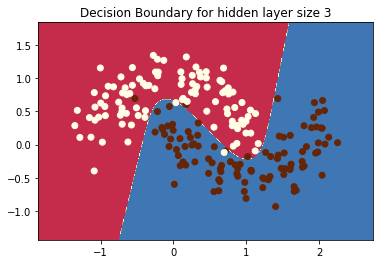

In [11]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

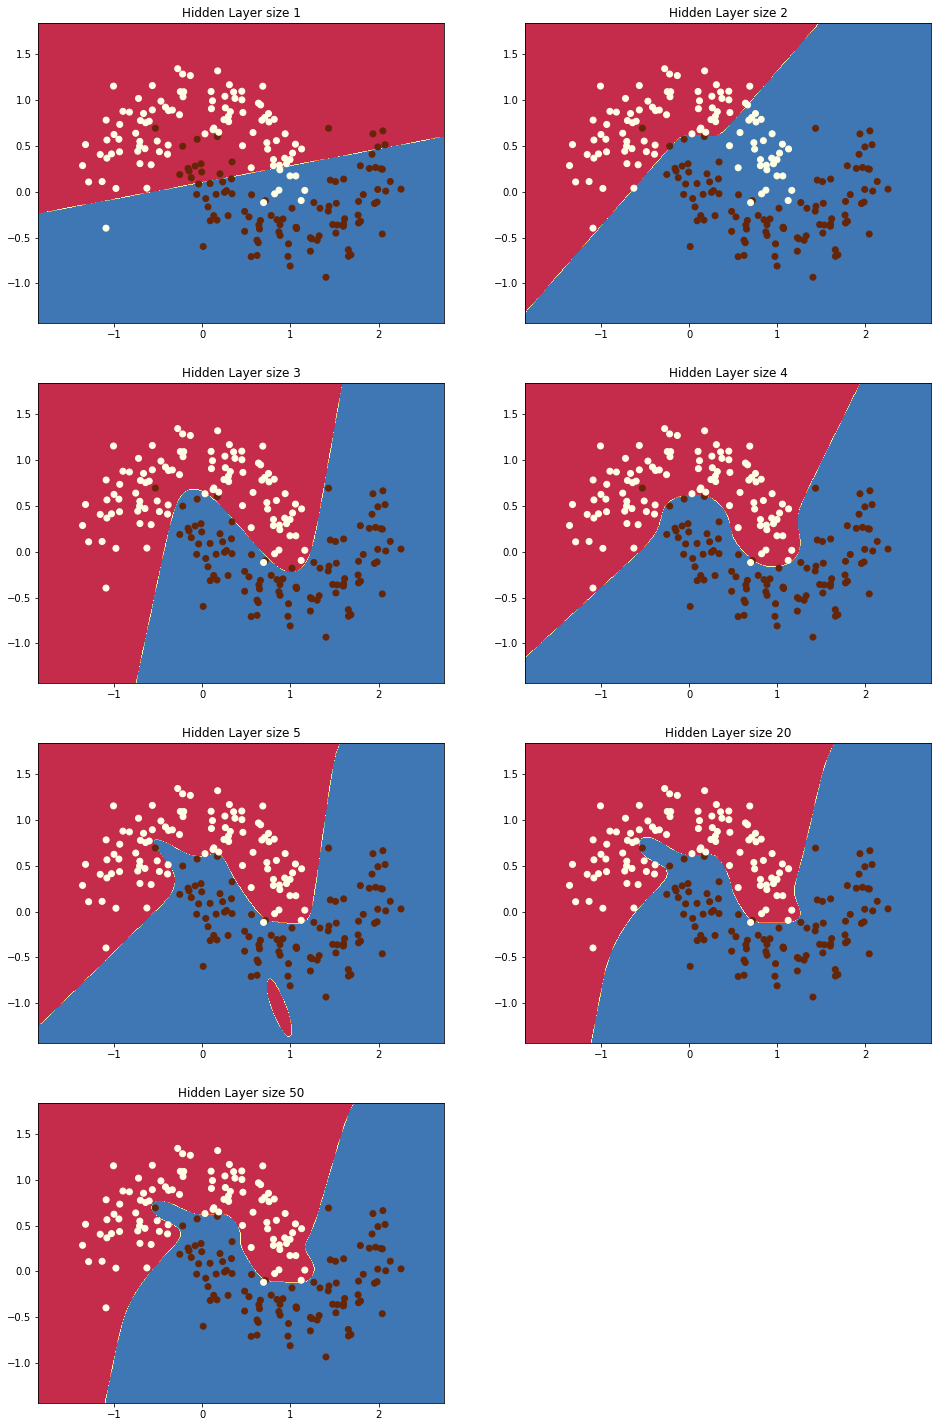

In [30]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim )
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

In [16]:
i = np.array([-2,2]) 
predict(model ,  i)

array([0], dtype=int64)

In [39]:
d2

[]